# 0. Introduction

This tutorial will:

- Use a small example dataset to show how to use wotplot to create and visualize binary dot plot matrices (**section 1**).

- Demonstrate the use of wotplot with not-binary dot plot matrices (**section 2**).

- Demonstrate a few techniques for creating fancy visualizations of dot plot matrices (**section 3**).

- Use wotplot to create and visualize a large dot plot matrix comparing two _E. coli_ genomes (**section 4**).

If you are unfamiliar with dot plot matrices, you may want to check out [the Wikipedia article on them](https://en.wikipedia.org/wiki/Dot_plot_(bioinformatics)). Chapter 6 of [_Bioinformatics Algorithms_](https://www.bioinformaticsalgorithms.org) also explains them well.

## 0.1. Import and set up a few things for later

In [2]:
import os
import wotplot
from matplotlib import pyplot
# the facecolor and transparent kargs force the saved figures to have a white background;
# from https://stackoverflow.com/a/64585557
savefig_kwargs = {"bbox_inches": "tight", "facecolor": "white", "transparent": False}

# 1. A small example

## 1.1. Define a small dataset

Adapted from Figure 6.20 in Chapter 6 of _Bioinformatics Algorithms_ (Compeau & Pevzner), edition 2.

In [3]:
s1 = "AGCAGGAGATAAACCTGT"
s2 = "AGCAGGTTATCTACCTGT"
k = 3

## 1.2. Create a dot plot matrix

In [4]:
m = wotplot.DotPlotMatrix(s1, s2, k)

## 1.3. Inspect the dot plot matrix

In [5]:
type(m)

wotplot._matrix.DotPlotMatrix

In [6]:
m

DotPlotMatrix(mat=<16x16 sparse matrix of type '<class 'numpy.int64'>'
	with 18 stored elements in COOrdinate format>, k=3, yorder="BT", binary=True)

In [7]:
print(str(m))

DotPlotMatrix(k = 3, binary, bottom → top): 16 x 16


The `DotPlotMatrix` object we just created, `m`, contains some extra information about the way it was created (e.g. the value of `k` we used). But the most interesting part of it is the actual matrix describing the dot plot! This matrix is stored in the `mat` attribute.

In [8]:
m.mat

<16x16 sparse matrix of type '<class 'numpy.int64'>'
	with 18 stored elements in COOrdinate format>

### 1.3.1. Why is this matrix 16x16? Shouldn't it be 18x18?

You might have noticed that `s1` and `s2` are 18 nucleotides long. Why, then, does `m.mat` only have 16 rows and 16 columns?

The reason for this is that the number of $k$-mers in an arbitrary string $s$ is slightly smaller than $|s|$: it's $|s| - k + 1$. For `s1` and `s2`, $|s| - k + 1 = 18 - 3 + 1 = 16$.

### 1.3.2. What's the deal with sparse matrices?

Most dot plot matrices are _sparse_: that is, most of their entries are zeroes. We exploit this by storing `m.mat` in a [sparse matrix format](https://en.wikipedia.org/wiki/Sparse_matrix), which allows us to only bother storing the non-zero entries—this drastically reduces the memory requirements when our input sequences are long (more than a few thousand nucleotides).

#### Sidenote: what's the exact type of `m.mat`?
Depending on the version of SciPy you have installed, `m.mat` will be of type [`scipy.sparse.coo_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html) (SciPy < 1.8) or type [`scipy.sparse.coo_array`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_array.html) (SciPy ≥ 1.8). There shouldn't be much of a difference, at least for our use of these objects.

In [9]:
import scipy
print(f"This notebook is using SciPy version {scipy.__version__}.")

This notebook is using SciPy version 1.5.2.


In [10]:
type(m.mat)

scipy.sparse.coo.coo_matrix

It's possible to convert `m.mat` from this sparse format to an equivalent "dense" format; this can make the matrix easier to work with, although it might require a large amount of memory if your input sequences were long. (For relatively small sequences like `s1` and `s2`, though, we should be fine.)

Here's an example of creating a dense version of `m.mat`:

In [11]:
m.mat.toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In the above matrix: `0` values represent cells where there are not any forward and/or reverse-complement $k$-mer matches, and `1` values represent cells where there is at least one such match.

For more details about these values, you can run `help(wotplot.DotPlotMatrix)`.

## 1.4. Visualize the dot plot matrix

### 1.4.1. Available visualization functions
Currently, we provide two functions for visualizing these matrices: `viz_imshow()` and `viz_spy()`. Both of these are essentially wrappers for matplotlib's [`imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) and [`spy()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.spy.html) functions; you can even provide additional keyword arguments to `viz_imshow()` and `viz_spy()` which will be passed directly to `imshow()` / `spy()`. 

A brief summary of (in my opinion) the most important differences between these functions:

- `imshow()`
  - Draws zero and nonzero matrix cells as the same size, giving a "perfect" representation of the exact matrix.
    - For small matrices (e.g. both sequences < 200 nt), this looks nice.
    - For large matrices, the nonzero cells may be hard to see without enlarging the figure.
  - Doesn't support sparse matrices.
    - This means that `viz_imshow()` has to convert the sparse matrix to a dense format before calling `imshow()`. This will require a lot of memory if your matrix is large.


- `spy()`
  - Only draws nonzero matrix cells, meaning that the points representing each cell may cover other close-by cells in the matrix.
    - You can increase / decrease nonzero cells' sizes as desired via the `markersize` parameter.
    - For large matrices, this way of drawing things is actually nicer than the "perfect" representation offered by `imshow()` -- it makes nonzero cells much easier to see.
  - Works with sparse matrices.
    - This makes `viz_spy()` much more memory-efficient than `viz_imshow()`.

In general, I recommend using `viz_imshow()` for small matrices (e.g. both sequences < 200 nt) and `viz_spy()` for large matrices.

### 1.4.2. `viz_imshow()`

First, let's use `viz_imshow()` -- our sequences here are very short, so the total cost of storing a dense 16 x 16 = 256-cell matrix in memory is small.

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$s_1$ (18 nt) →', ylabel='$s_2$ (18 nt) →'>)

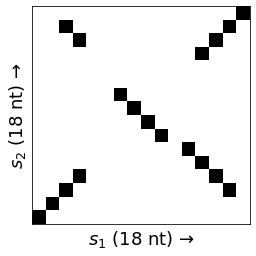

In [21]:
wotplot.viz_imshow(m)

By default, the visualization will use black cells (⬛) to represent matches (i.e. `1`s) and white cells (⬜) to represent no matches (i.e. `0`s).

#### Sidenote: `Figure` and `Axes` objects

What's the deal with the text above that says "`(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='$s_1$ (18 nt) →', ylabel='$s_2$ (18 nt) →'>)`"?

This text is showing up here because these two objects (a `matplotlib.figure.Figure` object and a `matplotlib.axes.Axes` object) are returned by `viz_imshow()` (and by `viz_spy()`).

Internally, these functions create a `Figure` and an `Axes` object on which to draw the visualization (using [`pyplot.subplots()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html)), and return these objects for convenience's sake.\* As we'll see later, it can be useful to have access to these objects -- for example, if we want to resize the plot, we can do this easily by calling the `set_size_inches()` method of the returned `Figure` object.

\* Note that this only applies if you leave the `ax` parameter of these functions set to the default of `None`. If you'd prefer, you can create these objects yourself and tell wotplot (using the `ax` parameter) to draw the dotplots on your specific `Axes` object -- this is useful when tiling multiple dot plots into a single figure, as is shown below in the section labelled "Tiling multiple dot plots".

### 1.4.3. For comparison's sake: `viz_spy()`

The default `markersize` used by `viz_spy()` is `0.5`. I set this as the default because it's useful for plots of very long sequences; however, it's less useful for plots of tiny sequences like this one.

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$s_1$ (18 nt) →', ylabel='$s_2$ (18 nt) →'>)

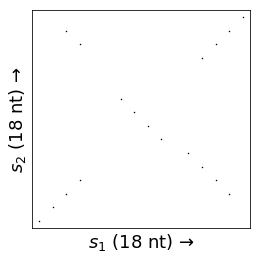

In [14]:
wotplot.viz_spy(m)

We can adjust the `markersize` when we call `viz_spy()`, which makes this visualization look essentially the same as what we'd get from `viz_imshow()`:

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$s_1$ (18 nt) →', ylabel='$s_2$ (18 nt) →'>)

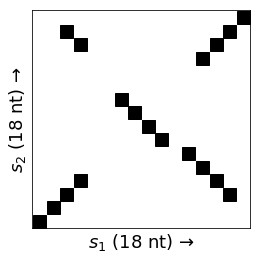

In [15]:
wotplot.viz_spy(m, markersize=13)

# 2. Distinguishing forward, reverse-complementary, and palindromic matches

If we set `binary=False` when creating a `DotPlotMatrix` object, then wotplot will distinguish between forward, reverse-complementary, and palindromic matches. This can be useful for certain analyses; also, we can color these matches differently in the visualization!

## 2.1. Using `binary=False` with the same dataset as above

In [16]:
n = wotplot.DotPlotMatrix(s1, s2, k, binary=False)

If we convert `n`'s matrix to a dense format, we see that now it doesn't just contain `0` and `1` values:

In [17]:
n.mat.toarray()

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,

In this not-binary matrix:

- `1` values indicate forward matches,
- `-1` values indicate reverse-complementary matches, and
- `2` values indicate palindromic matches (there aren't any of those in this example).

For reference, these values actually correspond to constants in wotplot's package (`wotplot.FWD`, `wotplot.REV`, and `wotplot.BOTH`, respectively; for binary matrices, `1` values correspond to `wotplot.MATCH`). If you're writing code that works with these matrices, I suggest using these constants instead of `1`, `-1`, etc.; this might improve readability a bit. (But it's not a huge deal.)

Okay, now let's draw this matrix! `viz_imshow()` will automatically notice that this matrix was created using `binary=False`, and will draw it in color.

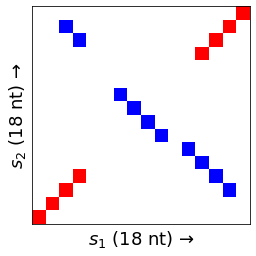

In [20]:
fig, ax = wotplot.viz_imshow(n)
# Since we include it in the README, we'll save this drawing to a file.
# We can do this using the fig object returned by viz_imshow() (or by viz_spy()).
fig.savefig(os.path.join("img", "small_example_dotplot.png"), **savefig_kwargs)

By default, the visualization will use red cells (🟥) to represent forward matches (i.e. `1`s), blue cells (🟦) to represent reverse-complementary matches (i.e. `-1`s), purple cells (🟪) to represent palindromic matches (i.e. `2`s), and white cells (⬜) to represent no matches (i.e. `0`s).

`viz_spy()` also works with `binary=False` matrices:

In [ ]:
wotplot.viz_spy(n, markersize=13)

## 2.2. Another dataset that includes palindromes

Just for demonstration, let's see how palindromic $k$-mers look in these visualizations. Note that palindromic $k$-mers can only occur for even values of $k$ (see [this discussion](https://bioinformatics.stackexchange.com/q/156) for details).

We'll create a "self dot plot," in which both the horizontal and vertical axes of the dot plot matrix correspond to the same sequence (named `s3` below). "Self dot plots" like this one can be helpful for visualizing self-similarity; for another example of a self dot plot, see [this visualization](https://commons.wikimedia.org/wiki/File:Zinc-finger-dot-plot.png) from [this Wikipedia page](https://en.wikipedia.org/wiki/Dot_plot_(bioinformatics)).

#### Sidenote: Aren't "self dot plots" like this symmetric?

Yep! Exactly _how_ your self dot plot is symmetric will depend on the `yorder` of your `wotplot.DotPlotMatrix` (see below), but all self dot plots will be symmetric in some way. If you wanted, you could only visualize one "triangle" of a self dot plot matrix; wotplot's built-in visualization functions don't support this (yet), but see [ModDotPlot](https://github.com/marbl/ModDotPlot) for an example of doing this.

In [ ]:
s3 = "AGCAGAAAGAGATAAACCTGT"
p = wotplot.DotPlotMatrix(s3, s3, 2, binary=False)
fig, ax = wotplot.viz_imshow(p)
# Adjust labels to make clear that both axes correspond to the same sequence
s3_lbl = f"$s_3$ ({len(s3)} nt) \u2192"
ax.set_xlabel(s3_lbl, fontsize=18)
ax.set_ylabel(s3_lbl, fontsize=18)

There are three palindromic $k = 2$-mers in `s3` (listed in the table below). These 2-mers are shown as purple cells in the visualization above.

| 2-mer | Starting position in `s3` (0-indexed) |
| --- | --- |
| `GC` | 1 |
| `AT` | 11 |
| `TA` | 12 |

## 2.3. Adjusting the color scheme

If you'd prefer something other than the default red / blue / purple / white colors, you can adjust this with the `nbcmap` parameter of `viz_imshow()`. `nbcmap` should be a `dict` mapping the four possible cell values (`0`, `1`, `-1`, `2`) to decimal RGB triplet colors (see [Wikipedia](https://en.wikipedia.org/wiki/Web_colors#Extended_colors) for context).

As an example, here we'll use `nbcmap` to create a "dark mode" version of the above dot plot:

In [ ]:
# it's gamer time
# no match = black; forward match = white; RC match = green; palindromic match = pink
dark_mode_cmap = {0: [0, 0, 0], 1: [255, 255, 255], -1: [0, 255, 0], 2: [255, 0, 255]}
fig, ax = wotplot.viz_imshow(p, nbcmap=dark_mode_cmap)
ax.set_xlabel(s3_lbl, fontsize=18)
ax.set_ylabel(s3_lbl, fontsize=18)

# 3. Other fancy visualization options

## 3.1. Tiling multiple dot plots; flipping the y-axis

One of the main reasons I wrote this library was so that I could create figures containing grids of many dot plots using matplotlib. wotplot makes this process fairly painless!

Here's an example of creating a single figure containing two side-by-side dot plots. For our second dot plot we'll reuse the original dataset from above but, this time, set `yorder="TB"` -- this will have the effect of "flipping" the y-axis so that the second sequence begins at the top and ends at the bottom of the plot. This is analogous to how [Gepard](https://academic.oup.com/bioinformatics/article/23/8/1026/198110)'s dot plots look.

In [ ]:
# Second dot plot: same as the original, but different y-order
m_flipped = wotplot.DotPlotMatrix(s1, s2, k, yorder="TB")

fig, (axLeft, axRight) = pyplot.subplots(1, 2)

# Notice how we provide an argument to the ax parameters of these functions.
# This way, we can create these Axes objects in advance (when we call pyplot.subplots()).
wotplot.viz_imshow(m, title="Bottom-to-top", ax=axLeft)
wotplot.viz_imshow(m_flipped, title="Top-to-bottom", ax=axRight)

fig.set_size_inches(12, 5)

## 3.2. Passing arbitrary keyword arguments to `imshow()` / `spy()`

These functions have a lot of options available (see [the matplotlib docs for `imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) and [the matplotlib docs for `spy()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.spy.html)), and we can make use of these options without too much effort:

In [ ]:
# - Set cmap to "viridis" (by default, viz_imshow() sets cmap to "gray_r" for binary matrices, but we can
#   override this here).
# - Set aspect to 0.5 (stretches out the x-axis; this can be useful if you're creating a dot plot where
#   the sequence used for the x-axis is smaller than the sequence used for the y-axis).
wotplot.viz_imshow(m, cmap="viridis", aspect=0.5)

In [ ]:
# - Set marker to "o" (draw circles instead of squares for matching cells).
# - Set alpha to 0.3 (add some transparency to the matching cells).
wotplot.viz_spy(m, markersize=13, marker="o", alpha=0.3)

## 3.3. Adding ticks, tick labels, and a grid (a.k.a. activating Fancy Mode)
We'll show this by reusing the above example.

Adding ticks can be a little complicated, especially if we want the labels to be correct. So this code is a bit long, sorry -- I've tried to document it thoroughly to make it easier to read.

In [ ]:
# While we're adding this other explanatory stuff, let's add a title for good measure.
fig, ax = wotplot.viz_spy(m, markersize=13, marker="o", alpha=0.3, title=f"Dot plot ($k = {m.k}$)")

###### PART 1: TICKS ######
# First, let's add ticks. We need to add ticks for ax.grid() to work.
# We'll add both major and minor ticks -- the major ticks will be used to position the grid lines,
# and the minor ticks will be used to position the tick labels. This allows us to center our labels
# in between ticks, which is nice when visualizing a matrix. This approach is inspired by
# https://matplotlib.org/stable/gallery/ticks/centered_ticklabels.html. (For context on major vs.
# minor ticks, see https://matplotlib.org/stable/gallery/ticks/major_minor_demo.html.)

# Our major ticks' positions will look like [-0.5, 0.5, 1.5, ..., 13.5, 14.5, 15.5]. We
# position them like this because the cells of the matrix occur at integer coordinates.
majticks = [t - 0.5 for t in range(0, 17)]

# We'll add minor ticks in between each of the major ticks. Our minor ticks use a smaller
# range than our major ticks because there are (n - 1) spaces between n consecutive points (e.g.
# your hands probably have 5 fingers each, but 4 spaces-between-fingers).
minticks = range(0, 16)

# The x-axis is simple -- we'll just use these major and minor ticks.
ax.set_xticks(majticks)
ax.set_xticks(minticks, minor=True)

# The y-axis is a bit more complicated. Keep in mind that, when creating the DotPlotMatrix "m"
# above, we left the DotPlotMatrix "yorder" parameter at its default value of "BT" -- so the
# y-axis goes from bottom to top.
#
# However, matplotlib doesn't know about this -- by default, it'll consider "row 0" to be the
# topmost row in the matrix, then row 1 the second-from-the-top row, ...)
# We can address this by adjusting the ticks on the y-axis (so that "row 0" is now the
# bottommost row, etc.) -- we'll do this using the t2y() function defined below.
def t2y(tl):
    return [m.mat.shape[0] - t - 1 for t in tl]
# Now, we can apply these corrected ticks to the y-axis.
ax.set_yticks(t2y(majticks))
ax.set_yticks(t2y(minticks), minor=True)

###### PART 2: TICK LABELS ######
# Next, let's add tick labels for the minor axis ticks. Adding one label for every minor tick
# is a bit excessive, so let's just add labels for every other minor tick. (For dot plots of
# long sequences, you'd probably want to add ticks and tick labels a lot farther apart -- e.g.
# separated by 1 Mbp.)
tick_labels = []
# Even though Python uses 0-indexing, we'll use 1-indexing here to make this plot a bit easier
# to interpret -- so we'll use range(1, 17) instead of range(0, 16).
for i in range(1, 17):
    if i % 2 == 1:
        # Only add labels for odd-numbered positions.
        tick_labels.append(f"{i:,}")
    else:
        # We still need to add something for the even-numbered positions (to match the
        # number of ticks we added above), so we'll add an empty string for each of these ticks.
        tick_labels.append("")

# Since we already reversed the ticks for the y-axis to account for how yorder="BT", we can now
# provide the tick labels for both the x- and y-axes in ascending order.
ax.set_xticklabels(tick_labels, minor=True)
ax.set_yticklabels(tick_labels, minor=True)

# Show ticks and labels on the left and bottom axes only
ax.tick_params(
    labeltop=False, labelbottom=True, labelleft=True, labelright=False,
    top=False, bottom=True, left=True, right=False, which="both"
)
# Also, don't show minor ticks' lines -- we'll still show their labels,
# but showing their tick lines (when we're already showing the major ticks' lines)
# is unnecessary (in my opinion)
ax.tick_params(bottom=False, left=False, which="minor")

###### PART 3: GRID LINES ######
# This part is easy :)
#
# We'll only draw grid lines for the major ticks -- this creates the nice appearance of minor
# ticks being lined up with their matrix rows / columns.
#
# Note that ax.grid() has a lot of other options you may want to play around with
# (linestyle, color, ...), should you want to transcend Fancy Mode. (Editor's note:
# Fancy Mode is not a real term and I made it up for this jupyter notebook.)
ax.grid(which="major")

# 4. Creating dot plots of longer sequences

As a final example, let's create a dot plot of two _E. coli_ strains' genomes. We'll use _E. coli_ K-12 [(from this assembly)](https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000005845.2/) and _E. coli_ O157:H7 [(from this assembly)](https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000008865.2/).

I haven't included these FASTA files in the repository because they're both fairly large (both around ~5 MB), but -- for reference -- I downloaded them from the NCBI's website, moved them to a folder in this repository named `docs/data/`, and removed the two plasmid sequences from the O157:H7 assembly. (The K-12 assembly doesn't include any plasmid sequences; I guess this makes sense, given [the history of the K-12 strain](https://en.wikipedia.org/wiki/Escherichia_coli_in_molecular_biology#K-12)?)

In [ ]:
# Note that pyfastx (https://github.com/lmdu/pyfastx), the library I use here to
# load these FASTA files' sequences into memory, isn't included as a dependency of
# wotplot; you can load your sequences however you'd like.
import pyfastx
e1 = pyfastx.Fasta(os.path.join("data", "ecoli_k12.fna"))
e2 = pyfastx.Fasta(os.path.join("data", "ecoli_o157h7.fna"))

In [ ]:
# Extract the sequences from these pyfastx.Fasta objects
e1s = str(e1[0])
e2s = str(e2[0])

#### Sidenote: how do I select the $k$-mer size when dealing with big sequences?
I don't have a single perfect answer. In general: smaller values of $k$ will show more details, but they'll increase the number of random matches between the two sequences, which will in turn increase the density of the dot plot matrix, which will in turn increase the memory footprint of the matrix. So you should consider the length of your sequences, their expected degree of similarity, what sort of "signals" you're looking for, and how much memory your system has when selecting the $k$-mer size.

If you're really curious, here are some vague, informal suggestions that might be a good starting point. For tiny sequences (e.g. < 100 bp), any $k$ should be ok. For small-ish sequences (e.g. 100 bp – 1 kbp), any $k > 2$ should be ok. For sequences in the range 1–100 kbp, I tend to use $k = 10$. For large sequences (e.g. > 100 kbp), I recommend using $k > 10$. (But none of this is written in stone, so please don't quote me on it...)

#### Sidenote: I didn't read that sidenote and you're bad at writing documentation
Wow, that's kind of harsh??? But don't worry, you didn't miss much.

## 4.1. Creating a binary dot plot matrix for the two _E. coli_ strains

We'll use a $k$-mer size of $k$ = 20. We'll also set `verbose=True` in order to get detailed logging output as the matrix is constructed -- this helps reassure us that wotplot isn't frozen.

In [ ]:
em = wotplot.DotPlotMatrix(e1s, e2s, 20, verbose=True)

Creating the matrix usually takes about 3 minutes (on my five-year old laptop with 8 GB of RAM). All things considered, not too shabby!

Now let's visualize the matrix. We pretty much have to use `viz_spy()` here -- using `viz_imshow()` is not feasible, because creating a dense-format copy of this matrix would require us to have... wait, how many cells were in that matrix?

In [ ]:
em.mat.shape

In [ ]:
f"The matrix has {em.mat.shape[0] * em.mat.shape[1]:,} cells."

Okay, so if we make the optimistic assumption that each cell in the matrix can be stored in a single bit (I don't think this is true even if the matrix is binary), then we'd still need ~3.19 terabytes (!!!) of memory to store the matrix in dense format. That's not happening on my laptop, so we'll have to use `viz_spy()`.

Again, we can use `verbose=True` for `viz_spy()` in order to get information about how long visualization is taking. (This should go by quickly, though -- visualization is fast, compared to the process of creating the matrix.)

In [ ]:
fig, ax = pyplot.subplots()
wotplot.viz_spy(
    em, markersize=0.01, title=f"Comparison of two $E. coli$ genomes ($k$ = {em.k})", ax=ax, verbose=True
)
ax.set_xlabel(f"$E. coli$ K-12 substr. MG1655 ({len(e1s)/1e6:.2f} Mbp) \u2192")
ax.set_ylabel(f"$E. coli$ O157:H7 str. Sakai ({len(e2s)/1e6:.2f} Mbp) \u2192")
fig.set_size_inches(8, 8)
fig.savefig(os.path.join("img", "ecoli_example_dotplot.png"), **savefig_kwargs)

There we have it! You may want to play around with the `markersize` parameter a bit in order to see what looks best.

## 4.2. Creating the two _E. coli_ strains' dot plot matrix with `binary=False`

When we're working with long sequences like these, the process of dot plot matrix visualization is a bit faster if we only want a binary matrix.

However, it is possible to create a not-binary matrix (distinguishing forward, reverse-complementary, and palindromic matches) from this massive dataset. Visualizing it just takes a few extra seconds.

In [ ]:
em_nb = wotplot.DotPlotMatrix(e1s, e2s, 20, binary=False, verbose=True)

In [ ]:
# em and em_nb should have the same dimensions!
em.mat.shape == em_nb.mat.shape

In [ ]:
# This code is the exact same as the above visualization of the binary E. coli matrix, 
fig, ax = pyplot.subplots()
wotplot.viz_spy(
    em_nb, markersize=0.01, title=f"Comparison of two $E. coli$ genomes ($k$ = {em_nb.k})", ax=ax, verbose=True
)
ax.set_xlabel(f"$E. coli$ K-12 substr. MG1655 ({len(e1s)/1e6:.2f} Mbp) \u2192")
ax.set_ylabel(f"$E. coli$ O157:H7 str. Sakai ({len(e2s)/1e6:.2f} Mbp) \u2192")
fig.set_size_inches(8, 8)

Visualizing this matrix took a little bit longer, but it looks pretty!

#### Sidenote: generating both binary and not-binary visualizations of a matrix at once

If you'd like, you can use the `force_binary` parameter of `viz_spy()` to draw the matrix as if it were binary. This way, you can generate both of the above versions of this dot plot without having to recompute the `DotPlotMatrix` object.